## Importing Libraries

In [4]:
from transformers import pipeline, AutoTokenizer, TFAutoModelForSeq2SeqLM
from bs4 import BeautifulSoup
import tf_keras as keras
import re
import requests

## Initializing Tokenizer, Summarizer and Sentiment Analysis models

In [5]:
# Initialize the tokenizer for the financial summarization model
tokenizer = AutoTokenizer.from_pretrained("human-centered-summarization/financial-summarization-pegasus")

# Initialize the summarization model
summarizer = TFAutoModelForSeq2SeqLM.from_pretrained("human-centered-summarization/financial-summarization-pegasus")

# Initialize the sentiment analysis pipeline using the FinBERT model
sentiment_analysis = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Initialize the tickers to be used in the sentiment analysis
# Using the top 2 cryptocurrencies as an example
tickers = ['BTC', 'ETH']

## Search news URL method

In [7]:
# Function to find news articles for a given ticker
def search_for_news_urls(ticker):
    # Construct the Google search URL for Yahoo Finance news related to the ticker
    search_url = f"https://www.google.com/search?q=yahoo+finance+{ticker}&tbm=nws"
    
    # Make a request to the search URL
    response = requests.get(search_url)
    
    # Parse the HTML content of the response
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all anchor tags in the parsed HTML content
    anchor_tags = soup.find_all('a')
    
    # Extract the href attributes from the anchor tags
    hrefs = [link['href'] for link in anchor_tags]
    
    return hrefs

In [8]:
# Create a dictionary where each ticker is mapped to its corresponding news article URLs
# The search_for_news_urls function is called for each ticker to get the news URLs
raw = {ticker: search_for_news_urls(ticker) for ticker in tickers}

# Display the keys of the raw dictionary, which are the tickers
raw.keys()

dict_keys(['BTC', 'ETH'])

## Cleaning Up URLs

In [9]:
# List of words to exclude
exclude = [
    'maps',
    'policies', 
    'preferences', 
    'accounts', 
    'support'
]

# Function to filter out unwanted URLs based on the list of excluded words
# @param urls: List of URLs to filter
# @param excludeList: List of words to exclude from URLs
# @return: List of filtered URLs
def filter(urls, excludeList):
    filtered_urls = []
    for url in urls:
        # Check if the URL starts with 'https://' and does not contain any excluded words
        if 'https://' in url and not any(word in url for word in excludeList):
            # Extract the URL up to the first '&' character
            cleaned_url = re.findall(r'(https?://\S+)', url)[0].split('&')[0]
            filtered_urls.append(cleaned_url)
    # Remove duplicates by converting the list to a set and back to a list
    return list(set(filtered_urls))

In [10]:
# Clean the URLs for each ticker by removing unwanted URLs based on the exclude list
# This creates a dictionary where each ticker is mapped to a list of cleaned URLs
cleanURLS = {ticker: filter(raw[ticker], exclude) for ticker in raw.keys()}

# Display the cleaned URLs for each ticker
cleanURLS

{'BTC': ['https://sg.finance.yahoo.com/news/bitcoins-double-top-suggests-btc-062739635.html',
  'https://finance.yahoo.com/news/bitcoin-signals-potential-bottom-market-053052099.html',
  'https://www.google.com/search?q%3Dyahoo%2Bfinance%2BBTC%26tbm%3Dnws%26pccc%3D1',
  'https://finance.yahoo.com/video/bitcoin-back-below-60k-look-133426663.html',
  'https://sg.finance.yahoo.com/news/48-singapore-crypto-investors-double-130000395.html',
  'https://finance.yahoo.com/news/bitcoin-is-having-its-worst-week-since-the-fall-of-ftx-153406320.html',
  'https://finance.yahoo.com/news/bitcoin-price-today-down-58k-062123138.html',
  'https://sg.finance.yahoo.com/news/bitcoin-summer-2024-expect-153233549.html',
  'https://sg.finance.yahoo.com/news/bitcoin-could-reach-high-us-023053354.html',
  'https://finance.yahoo.com/video/bitcoin-rebound-markets-recover-market-215949834.html',
  'https://sg.finance.yahoo.com/news/bitcoin-halving-prices-another-high-074351948.html'],
 'ETH': ['https://finance.yah

## Scraping content

In [14]:
import time
import random

# Function to scrape articles from a list of URLs
# @param urls: List of URLs to scrape
# @return: List of articles' text content
def scrape(urls):
    articles = []
    
    # Define the header to mimic a browser request
    header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    for url in urls:
        # Delay between requests for a random amount of time (1 to 5 seconds) to reduce the chances of being blocked
        time.sleep(random.randint(1, 5))
        
        # Make a request to the URL with the defined header
        response = requests.get(url, headers=header)
        
        # Parse the HTML content of the response
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find all paragraph tags in the parsed HTML content
        paragraphs = soup.find_all('p')
        
        # Extract the text from each paragraph and join them into a single string
        text = [paragraph.text for paragraph in paragraphs]
        
        # Limit the text to the first 350 words for summarization
        words = ' '.join(text).split(' ')[:350]
        article = ' '.join(words)
        
        # Append the cleaned article text to the articles list
        articles.append(article)
    
    return articles

In [15]:
articles = {ticker: scrape(cleanURLS[ticker]) for ticker in tickers}
articles

{'BTC': ['The U.S. election and CPI could be a bullish factor later this year. Fed\'s preferred inflation gauge, the PCE price index, due Friday, could offer relief. Bitcoin {{BTC}} has carved out a double-top price pattern, signaling a potential bearish trend change ahead of key data release that could influence the Fed\'s interest rate path. Bitcoin\'s price journey has been a rollercoaster this month. After surging to nearly $70,000, approaching the all-time high of March, it has now retreated to $63,000, decoupling from Nasdaq\'s continued move higher, largely due to faster selling by miners, profit-taking by investors near lifetime highs, and outflows from the U.S.-listed spot exchange-traded funds. The price action has formed a double top, a bearish technical analysis pattern comprising two peaks with a valley in the middle, usually appearing after a notable uptrend. The second peak represents uptrend exhaustion, with the eventual breach of the low hit between the two peaks confi

## Summarizing content

In [20]:
# Function to summarize a list of articles in batches
# @param art: List of articles to summarize
# @param batch_size: Number of articles to summarize at once
# @return: List of summarized articles
def summarize(art, batch_size):
    summaries = []
    
    # Process articles in batches
    for i in range(0, len(art), batch_size):
        # Get the current batch of articles
        batch = art[i:i + batch_size]
        
        # Tokenize the batch of articles
        input_ids = tokenizer(batch, return_tensors='tf', padding=True, truncation=True).input_ids
        
        # Generate summaries for the batch
        output = summarizer.generate(input_ids, max_length=55, num_beams=5, early_stopping=True)
        
        # Decode the generated summaries and add them to the summaries list
        batch_summaries = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]
        summaries.extend(batch_summaries)
    
    return summaries

In [21]:
# Summarize articles for each ticker in batches that can be defined by the batch_size parameter
# This creates a dictionary where each ticker is mapped to a list of summarized articles
# Note: This process may take about 5 minutes to complete
summaries = {ticker: summarize(articles[ticker], 8) for ticker in tickers}

# Display the dictionary of summarized articles
summaries

{'BTC': ['Slower U.S. inflation, U.S. election could be bullish for crypto',
  'Transaction Golden Cross (NVT-GC) tool suggests local bottom.',
  'Your information may be shared with third parties.',
  'A look back at the past few months of volatility for the digital asset. Bitcoin ETF inflows have been light in recent months',
  'Almost half (48%) of those surveyed believe a Bitcoin will be worth between $50,000 and $100,000',
  'The world’s largest cryptocurrency fell 20% over the last week. Ether briefly saw its biggest single-day drop since late 2021',
  'Ripple ordered to pay a fraction of SEC penalties. Ether added 2.4% following strong rally last week',
  'Ethereum ETF approval seen as next potential catalyst. crypto headwinds include distribution, supply overhang',
  'Using gold as a proxy for Bitcoin suggests price will settle around US$200,000. Rapid ETF inflows suggest positioning should be more sustainable',
  'Janney Montgomery Scott sees more volatility over next couple o

## Sentiment Analysis

In [22]:
# Perform sentiment analysis on the summarized articles for each ticker
# This creates a dictionary where each ticker is mapped to a list of sentiment scores
scores = {ticker: sentiment_analysis(summaries[ticker]) for ticker in tickers}

# Display the dictionary of sentiment scores
scores

{'BTC': [{'label': 'Positive', 'score': 0.9999908208847046},
  {'label': 'Neutral', 'score': 0.5085883736610413},
  {'label': 'Neutral', 'score': 0.9999245405197144},
  {'label': 'Negative', 'score': 0.999992847442627},
  {'label': 'Neutral', 'score': 0.9999943971633911},
  {'label': 'Negative', 'score': 0.9996800422668457},
  {'label': 'Positive', 'score': 0.9997122883796692},
  {'label': 'Negative', 'score': 0.9999910593032837},
  {'label': 'Positive', 'score': 1.0},
  {'label': 'Neutral', 'score': 0.999826967716217},
  {'label': 'Neutral', 'score': 0.9999972581863403}],
 'ETH': [{'label': 'Positive', 'score': 0.9997666478157043},
  {'label': 'Neutral', 'score': 0.6885908842086792},
  {'label': 'Neutral', 'score': 0.9989998936653137},
  {'label': 'Neutral', 'score': 0.999953031539917},
  {'label': 'Positive', 'score': 0.9092445969581604},
  {'label': 'Neutral', 'score': 0.7256548404693604},
  {'label': 'Neutral', 'score': 0.9999245405197144},
  {'label': 'Positive', 'score': 0.999998

## Plotting Results

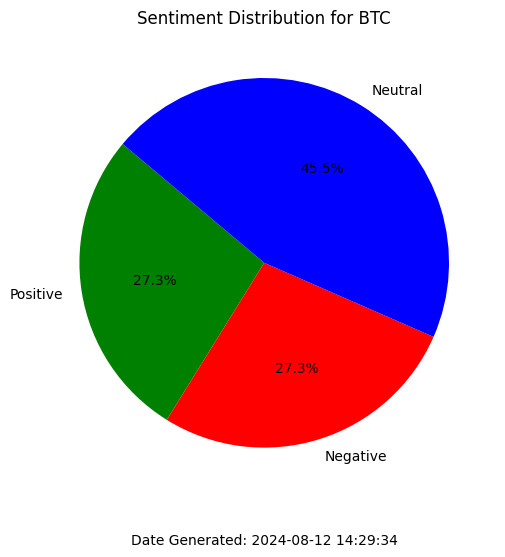

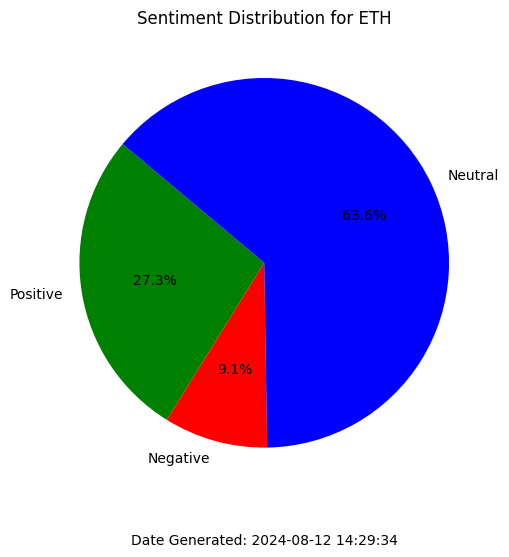

In [28]:
from matplotlib import pyplot as plt

# Initialize the date generated to the current date and time
date_generated = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

# Initialize a dictionary to count the number of positive, negative, and neutral sentiments for each ticker
counts = {ticker: {'Positive': 0, 'Negative': 0, 'Neutral': 0} for ticker in scores.keys()}

# Count the number of positive, negative, and neutral sentiments for each ticker
for ticker, sentiments in scores.items():
    for sentiment in sentiments:
        counts[ticker][sentiment['label']] += 1

# Plot pie charts for each ticker to visualize the sentiment distribution
for ticker, sentiment_counts in counts.items():
    labels = list(sentiment_counts.keys())  # Labels for the pie chart (Positive, Negative, Neutral)
    sizes = list(sentiment_counts.values())  # Sizes for each sentiment category
    colors = ['green', 'red', 'blue']  # Colors for each sentiment category
    
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Sentiment Distribution for {ticker}')  # Title of the pie chart
    # Add the date generated at the bottom of the chart
    plt.text(0.5, -0.1, f'Date Generated: {date_generated}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.show()  # Display the pie chart

## Exporting as csv

In [24]:
# Function to export summarized articles, sentiment scores, and URLs into a structured format
# @param summaries: Dictionary of summarized articles for each ticker
# @param score: Dictionary of sentiment scores for each ticker
# @param urls: Dictionary of URLs for each ticker
# @return: List of lists containing ticker, summary, sentiment label, sentiment score, and URL
def export(summaries, score, urls):
    output = []
    
    # Iterate through each ticker
    for ticker in tickers:
        # Iterate through each summary for the current ticker
        for i in range(len(summaries[ticker])):
            # Create a data entry with ticker, summary, sentiment label, sentiment score, and URL
            data = [
                ticker,                      # Ticker symbol
                summaries[ticker][i],        # Summarized article
                score[ticker][i]['label'],   # Sentiment label (Positive, Negative, Neutral)
                score[ticker][i]['score'],   # Sentiment score
                urls[ticker][i]              # URL of the article
            ]
            # Append the data entry to the output list
            output.append(data)
    
    return output

In [25]:
output = export(summaries, scores, cleanURLS)
output.insert(0, ['Ticker', 'Summary', 'Sentiment', 'Confidence', 'URL'])

In [26]:
import csv
with open('asset-analysis.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(output)